# DST forecasting from OMNI data

This example shows how to use AIDApy to perform the following tasks:

* Download time series data from OMNI
* Preprocess the data so that it can be used for machine learning
* Train several models and evaluate their performance


## Downloading data

We will first download low-resolution data from [OMNI](https://omniweb.gsfc.nasa.gov/).


In [1]:
from datetime import datetime
from aidapy import load_data

# Set the start and end date as year, month, day
t0 = datetime(2005, 1, 1)
t1 = datetime(2015, 12, 31)

# Download the data
omnixr = load_data(mission='omni', start_time=t0, end_time=t1)

# Store data in pandas format
pd_data = omnixr['all1'].to_pandas()

pd_data.describe()

products,Bartels Rotation Number,ID IMF Spacecraft,ID SW Plasma Spacecraft,points(IMF Average),points(Plasma Average),|B|,Magnitude of Avg Field Vector,Lat. Angle of Aver. Field Vector,Long. Angle of Aver. Field Vector,"Bx GSE, GSM",...,Proton Flux > 10MeV,Proton Flux > 30MeV,Proton Flux > 60MeV,flag,ap index,f10.7 index,PC(N) index,AL index (Kyoto),AU index (Kyoto),Magnetosonic Mach No.
count,96385.000000,96385.000000,96354.00000,96385.000000,96354.00000,96385.000000,96385.000000,96385.000000,96385.000000,96385.000000,...,91174.000000,91171.000000,91169.000000,96385.000000,96385.000000,96265.000000,96212.000000,96385.000000,96385.000000,95501.000000
mean,2413.760481,51.469160,52.41442,58.407595,34.32062,5.216666,4.620777,0.442976,200.817234,-0.003756,...,4.467667,0.895241,0.283256,-0.945936,8.207802,98.542824,0.876475,-93.396431,56.163034,5.769463
std,42.939382,3.027076,2.95985,7.630976,5.37908,2.785629,2.659993,29.518247,101.021925,3.079144,...,74.289989,15.688849,5.969648,0.226146,12.072234,29.679255,1.171071,128.300576,61.312826,1.119411
min,2339.000000,51.000000,51.00000,1.000000,1.00000,0.400000,0.100000,-89.200000,0.000000,-40.800000,...,0.050000,0.040000,0.030000,-1.000000,0.000000,65.100000,-6.900000,-2452.000000,-225.000000,0.600000
25%,2377.000000,51.000000,52.00000,58.000000,34.00000,3.400000,2.900000,-18.600000,121.100000,-2.200000,...,0.140000,0.080000,0.060000,-1.000000,3.000000,73.500000,0.100000,-120.000000,17.000000,5.100000
50%,2414.000000,51.000000,52.00000,60.000000,36.00000,4.600000,4.000000,0.100000,182.600000,0.000000,...,0.180000,0.100000,0.070000,-1.000000,5.000000,88.400000,0.600000,-38.000000,34.000000,5.800000
75%,2451.000000,51.000000,52.00000,61.000000,37.00000,6.200000,5.600000,19.200000,300.600000,2.200000,...,0.220000,0.120000,0.090000,-1.000000,9.000000,117.800000,1.300000,-17.000000,72.000000,6.500000
max,2488.000000,71.000000,71.00000,91.000000,52.00000,55.400000,54.500000,89.800000,360.000000,26.400000,...,4559.950000,1210.000000,956.000000,0.000000,300.000000,255.000000,18.400000,15.000000,873.000000,10.900000


Split the data into different sets
--

For evaluating the performance of a machine learning approach, the input data has to be split in different sets:

* A training set, on which the model is trained
* Optionally, a validation set, to tune so-called hyperparameters of the model
* A test set, which is only used at the end to evaluate the performance of the model

Such a separation is important to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting). Since there is usually a correlation between consecutive observations in a time series, it is important not to shuffle the data before splitting it in different sets. Otherwise, the test set would not be truly independent from the training set.


In [2]:
from sklearn.model_selection import train_test_split

# Split into training and test data
dtrain, dtest = train_test_split(pd_data, shuffle=False)

## Let's have a look at the data

Below, the DST index is shown. Note that there are quiet periods, and periods with more magnetic storms, indicated by large negative values.

<IPython.core.display.Javascript object>


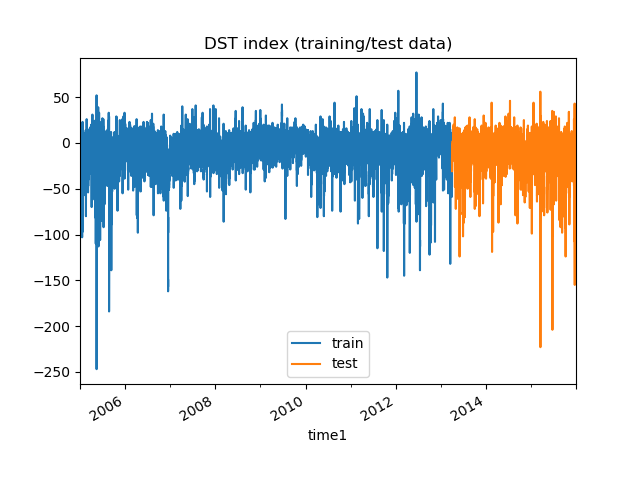

In [3]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib notebook
register_matplotlib_converters()

plt.figure()
plt.title("DST index (training/test data)")
dtrain['DST Index'].plot(label='train')
dtest['DST Index'].plot(label='test')
plt.gcf().autofmt_xdate()
plt.legend();

## Selecting features

The features are here selected by hand (and they are not necessarily the best ones).

In [4]:
features = ['|B|', 
            'Magnitude of Avg Field Vector',
            'Proton Density',
            'Proton Temperature',
            'Alfven Mach Number',
            'Bz GSM',
            'Na/Np',
            'Plasma Flow Speed',
            'Plasma Beta',
            'Electric Field',
            'DST Index']
targets = ['DST Index']

## Preprocessing data

The training and test data are preprocessed so that we can make predictions for the targets based on a history of the features. If the original features and targets are $X_i$ and $y_i$, then we define new features $X_i' = [X_i, X_{i-1}, \dots, X_{i-n-1}]$, where $n$ is the history size. We use these features to make predictions at some future time, so that the new targets are $y_i' = y_{i+k}$, where $k$ is the forecast time.

Another question is what to do with missing values. This is a common issue in working with space craft data -- in particular if data from multiple instruments is combined. We have opted for a simple approach: remove all samples for which some data is missing, either in the features or the targets.

In [5]:
from aidapy.ml import preprocess

histsize = 8                    # Number of past hours
forecast_time = 1               # Hours into the future

# Use the AIDApy preprocessing method for time series
X_train, y_train, mask_train = preprocess.time_series(
    dtrain[features].values, dtrain[targets].values, histsize, forecast_time)
X_test, y_test, mask_test = preprocess.time_series(
    dtest[features].values, dtest[targets].values, histsize, forecast_time)

t_train = dtrain.index[mask_train]
t_test = dtest.index[mask_test]

## Regression models

For the first use case, the following regression models are used:
* A fully-connected neural network implemented in PyTorch. Users can customize the number of layers, the number of neurons per layer, and the activation functions of the layers.
* A linear regression model imported from scikit-learn

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from aidapy.ml import mlp
from skorch import NeuralNetRegressor
import torch

models = []

models.append({
    'name': 'Linear Regression',
    'pipe': Pipeline(steps=[('preprocess', StandardScaler()),
                            ('model', LinearRegression())])
})

# RegressorMlp is a simple, fully-connected neural network, 
# for which the layer sizes are defined below. The default
# activation function is ReLU.
mlp_model = NeuralNetRegressor(
    mlp.RegressorMlp,
    max_epochs=25,
    lr=0.001,
    batch_size=128,
    optimizer=torch.optim.Adam,
    module__layer_sizes=[X_train.shape[1], 64, 64, 64, 1]
)

models.append({
    'name': 'Multilayer perceptron',
    'pipe': Pipeline(steps=[('preprocess', StandardScaler()),
                            ('model', mlp_model)])
})

In [7]:
from sklearn.metrics import r2_score

for model in models:
    model['pipe'].fit(X_train, y_train)
    model['test_predict'] = model['pipe'].predict(X_test)
    model['train_predict'] = model['pipe'].predict(X_train)
    
for model in models:
    print("{:30} R2 score on test / train set:  {:8.3f} {:8.3f}".format(
        model['name'], r2_score(y_test, model['test_predict']),
        r2_score(y_train, model['train_predict'])))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       60.7240       32.4020  2.9466
      2       17.2051       27.2859  1.8680
      3       13.9108       27.3186  4.9162
      4       11.7659       25.7481  3.9948
      5       11.0440       29.0479  2.6648
      6       10.3904       26.3400  2.7699
      7       10.1087       27.2759  1.9154
      8        9.7082       24.8305  2.6972
      9        9.3186       24.3196  2.6852
     10        9.0785       23.8498  3.3641
     11        8.9514       23.7893  2.6362
     12        8.8422       23.3065  4.0155
     13        8.6888       22.9633  2.9111
     14        8.4773       21.6068  2.7943
     15        8.4333       22.4387  2.9364
     16        8.2843       21.1695  3.0378
     17        8.1932       21.9871  3.1358
     18        8.0966       20.9862  3.1069
     19        8.1332       22.9881  3.7974
     20        7.9812       20.2496  4.5640
     21        7.9269       21.3

Let's compare the predictions with the actual data

<IPython.core.display.Javascript object>


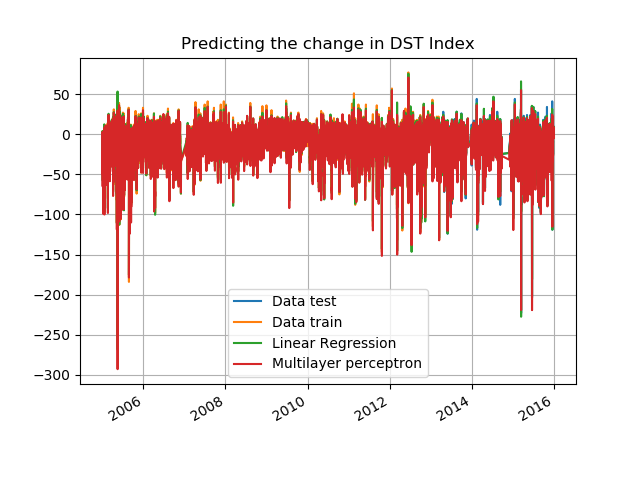

In [8]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(t_test, y_test, label='Data test')
plt.plot(t_train, y_train, label='Data train')
for model in models:
    p = plt.plot(t_test, model['test_predict'], label=model['name'])
    # Plot another line with the same color
    plt.plot(t_train, model['train_predict'], color=p[0].get_color())
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

## This looks pretty good, but...

Most variables we consider in a time series have strong auto-correlation. This means that future values strongly resemble past values; examples are the temperature at a location on earth or the price of a stock on a stock market. When making predictions for a variable with strong auto-correlation, one has to be careful in assessing the predictive power of a model. Simply predicting the past state as the future state can look convincing (also numerically in most error norms), but gives little information. 

Below, we therefore take the following approach: predict the change in the variable.

In [9]:
from aidapy.ml import preprocess

histsize = 24                   # Number of past hours
forecast_time = 1               # Hours into the future

# Use the AIDApy preprocessing method for time series
# With the predict_change=True flag, the change in the DST index 
# is the target variable
X_train, y_train, mask_train = preprocess.time_series(
    dtrain[features].values, dtrain[targets].values,
    histsize, forecast_time, predict_change=True)
X_test, y_test, mask_test = preprocess.time_series(
    dtest[features].values, dtest[targets].values, 
    histsize, forecast_time, predict_change=True)

t_train = dtrain.index[mask_train]
t_test = dtest.index[mask_test]

models = []

models.append({
    'name': 'Linear Regression',
    'pipe': Pipeline(steps=[('preprocess', StandardScaler()),
                            ('model', LinearRegression())])
})

# RegressorMlp is a simple, fully-connected neural network, 
# for which the layer sizes are defined below. The default
# activation function is ReLU.
mlp_model = NeuralNetRegressor(
    mlp.RegressorMlp,
    max_epochs=25,
    lr=0.001,
    batch_size=128,
    optimizer=torch.optim.Adam,
    module__layer_sizes=[X_train.shape[1], 64, 64, 64, 1]
)

models.append({
    'name': 'ANN',
    'pipe': Pipeline(steps=[('preprocess', StandardScaler()),
                            ('model', mlp_model)])
})

In [10]:
from sklearn.metrics import r2_score

for model in models:
    model['pipe'].fit(X_train, y_train)
    model['test_predict'] = model['pipe'].predict(X_test)
    model['train_predict'] = model['pipe'].predict(X_train)
    
for model in models:
    print("{:30} R2 score on test / train set:  {:8.3f} {:8.3f}".format(
        model['name'], r2_score(y_test, model['test_predict']),
        r2_score(y_train, model['train_predict'])))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        9.3040       13.4525  2.5473
      2        8.0748       13.2288  2.4043
      3        7.6921       12.3340  2.4899
      4        7.5276       12.2525  3.9910
      5        7.3974       12.1197  3.8056
      6        7.2771       11.9705  3.0214
      7        7.1804       11.9094  2.0155
      8        7.0822       11.9217  2.8191
      9        7.0014       11.8192  2.6564
     10        6.8758       11.8942  2.6622
     11        6.7928       11.8929  1.9705
     12        6.6663       11.8819  1.9809
     13        6.6267       12.3010  2.6679
     14        6.5041       12.2031  1.8921
     15        6.4059       12.2843  2.4354
     16        6.3420       12.9039  3.0471
     17        6.2806       12.1478  2.7479
     18        6.1105       13.0912  4.9462
     19        6.0671       12.2712  4.6252
     20        5.9791       12.7974  1.9119
     21        5.9633       12.8

<IPython.core.display.Javascript object>


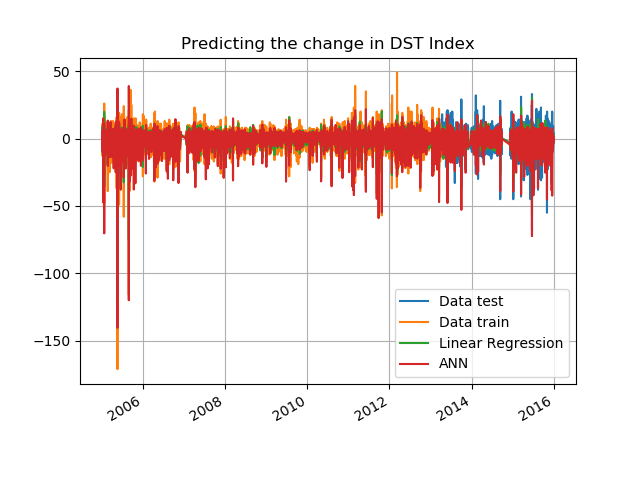

In [11]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(t_test, y_test, label='Data test')
plt.plot(t_train, y_train, label='Data train')
for model in models:
    p = plt.plot(t_test, model['test_predict'], label=model['name'])
    # Plot another line with the same color
    plt.plot(t_train, model['train_predict'], color=p[0].get_color())
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)